### Load packages and define data cleaning functions

In [1]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import geopandas
from scipy.stats import pearsonr
import math
import gender_guesser.detector as gender

In [2]:
# functions for cleaning numerical attributes

def rm_leading_char(x): # introduced to remove a leading $ sign; also removes a comma
    try:
        return float(x.replace(",","")[1:])
    except:
        return np.NAN

def rm_trailing_char(x): # introduced to remove % sign; also removes a comma
    try:
        return float(x.replace(",","")[:-2])
    except:
        return np.NAN

### Load data into dataframes

In [3]:
# load datasets and print attributes/columns

cal=pd.read_csv("data/calendar.csv")  # load availability and actual price data from 04th of Jan. 2016 to the 3rd of January 2017
lis=pd.read_csv("data/listings.csv")  # load listings
rev=pd.read_csv("data/reviews.csv")   # load reviews from customers

### Preview dataframes

Now, it is time to get some insights by looking at the dataframes' attributes and some data of each.
In addition, the shape will be plotted as well.

In [4]:

# print shape and preview of "cal" dataframe - availability and actual price data
print("Shape of \"cal\": ",cal.shape)
print("Preview:")
cal.head(5)

Shape of "cal":  (1393570, 4)
Preview:


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
# print shape and preview of "lis" dataframe - listings data
print("Shape of \"lis\": ",lis.shape)
print("Preview:")
lis.head(5)

Shape of "lis":  (3818, 92)
Preview:


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [6]:
# print shape and preview of "rev" dataframe - reviews from customers data
print("Shape of \"rev\": ",rev.shape)
print("Preview:")
rev.head(5)

Shape of "rev":  (84849, 6)
Preview:


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


By looking at the data and doing some crisp-dm iterations, the following questions arised.



### Questions to be addressed:

**1. How large is the deviation of each accommodation's price from its list price by area?**

**2. Is there a relationship between host response rate and review scores value?**

**3. Does the rating depend on the reviewer's and host's gender?**

#### Question 1: How large is the deviation of each accommodation's price from its list price by area?

For each Airbnb accommodation, there is a listing price provided.
However, the available price fluctuates every day. The price deviation depends on the booking status and season, and more.
The listing price is just an orientation. But is it a good one for each place in Seattle?  

In the next code block, the dataframe "cal" containing the available or real prices by each day and the dataframe "lis" containing the listing prices are "inner"-joined with the "listing_id"'s. The resulting dataframe "cal_lis" allows for a direct comparison of the two prices for each day and each Airbnb accommodation. 
In addition, "cal_lis" undergoes some data cleaning concerning the aforementioned prices.

In [7]:
# define new dataframe "cal_lis" as a merge of "cal" and "lis"
cal_lis=pd.merge(cal,lis,how='inner',left_on='listing_id',right_on='id')


# data cleaning: lis.price->lis.listing_price   and   cal.price -> cal.available_price
cal_lis['listing_price']=cal_lis.price_y.apply(rm_leading_char) # new attribut where first character-which is a $-sign- is removed
cal_lis.drop(columns=['price_y'],inplace=True)
cal_lis['available_price']=cal_lis.price_x.apply(rm_leading_char) # new attribut where first character-which is a $-sign- is removed
cal_lis.drop(columns=['price_x'],inplace=True)

The so-formed dataframe "cal_lis" should contain relevant data for our question.
In the following a dataframe "prices_per_neighbourhood" is developed aiming to provide some insights for each neighourhood.
In particular, it comprises for each neighbourhood:
* the number of listings
* the average listing price (an average over all accommodations in "lis", i.e. it is irrespective of calendar availability data)
* the typical deviation of listing prices (the average price deviation for each accommodation over a year is averaged over all neighbourhoods accommodations).



In [8]:

# number of accomodations (listings) per neighbourhood
temp=lis[['neighbourhood']].groupby(['neighbourhood'],as_index=False).value_counts()
temp.rename(columns={"count": "listings"},inplace=True)
temp.sort_values(by='listings',inplace=True,ascending=False)
listings_per_neighbourhood=temp

# average list price per neighbourhood
temp=cal_lis[['neighbourhood','listing_price']].groupby(['neighbourhood'],as_index=False).mean()
temp.rename(columns={"listing_price": "average listing price"},inplace=True)
temp.sort_values(by="average listing price",inplace=True,ascending=False)
avg_listing_price_per_neighbourhood=temp

# average daily deviation from each accommodation's list price averaged over all listings in a neighbourhood
temp=cal_lis[['listing_id','available_price','listing_price', 'neighbourhood']].copy()
temp['deviation_from_listing_price']=temp['available_price']-temp['listing_price']
temp=temp.groupby(['listing_id', 'neighbourhood'],as_index=False).mean()
temp.rename(columns={"deviation_from_listing_price": "avg_deviation_from_accommodations_listing_price"},inplace=True)
temp=temp[["neighbourhood", "avg_deviation_from_accommodations_listing_price"]].groupby(['neighbourhood'],as_index=False).mean()
temp.rename(columns={"avg_deviation_from_accommodations_listing_price": "typical deviation from accommodations listing price"},inplace=True)
price_fluct_per_neighbourhood=temp

# putting all 3 dataframes together
temp=pd.merge(listings_per_neighbourhood,avg_listing_price_per_neighbourhood,on="neighbourhood")
prices_per_neighbourhood=pd.merge(temp,price_fluct_per_neighbourhood,on="neighbourhood")

The dataframe "prices_per_neighbourhood" is shown next being ordered by the average listing price in descending order.

In [9]:
# Dataframe "price_per_neighbourhood" sorted by "average list price" descending
prices_per_neighbourhood.sort_values(by=['average listing price', "listings"],inplace=True,ascending=False)
prices_per_neighbourhood.reset_index()
prices_per_neighbourhood.iloc[0:15].style.hide(axis="index")

neighbourhood,listings,average listing price,typical deviation from accommodations listing price
Fairmount Park,1,370.000000,0.000000
Industrial District,3,245.000000,4.675926
Portage Bay,14,241.428571,10.481521
Westlake,12,197.000000,1.608584
Alki,23,196.652174,14.862521
Montlake,19,195.947368,0.494363
Magnolia,55,176.000000,16.497812
Pike Place Market,39,175.512821,18.685403
Windermere,10,174.700000,53.754500
Queen Anne,187,168.764706,11.063264


The most expensive neighbourhoods regarding the listing price have only a few listings with a rather fixed price.
Now, let us focus on those neighbourhoods possessing accommodations with the highest typical deviation from accommodations listing prices.

In [10]:

# Dataframe "price_per_neighbourhood" sorted by "typical deviation from accommodations listing price" descending
prices_per_neighbourhood.sort_values(by=['typical deviation from accommodations listing price', "listings"],inplace=True,ascending=False)
prices_per_neighbourhood.reset_index()
prices_per_neighbourhood.iloc[0:15].style.hide(axis="index")

neighbourhood,listings,average listing price,typical deviation from accommodations listing price
Pike Market,2,92.000000,100.477140
Windermere,10,174.700000,53.754500
Central Business District,81,163.728395,39.767041
Pinehurst,3,138.000000,37.631818
Belltown,204,166.627451,32.376357
Interbay,7,102.000000,20.991399
Pike Place Market,39,175.512821,18.685403
Magnolia,55,176.000000,16.497812
South Lake Union,21,154.142857,14.897705
Alki,23,196.652174,14.862521


It turns out that downtown areas (Pike (Place) Market, Belltown, Central Business District) are among those neighbourhoods with the 
highest price deviation even though their listings are not announced as quite expensive ones.

This is also highlighted in the next graphics.
It represents the average deviation of the accommodations' price from their listing prices for each given accommodation throughout available days in a year.
Hereby, only two different colors were used.
If the difference is over 70$ then it is painted red, otherwise blue.
Downtown areas are highlighted in gray.

##### Create an image to visualize price fluctuations for Airbnb locations in Seattle

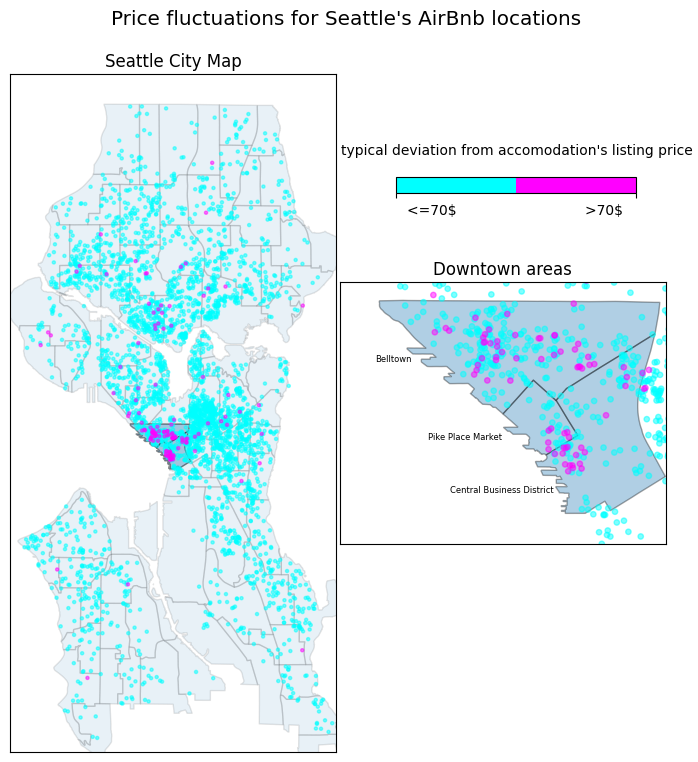

In [11]:

# create view
thresh_value=70

# calculate dataframe "airbnb_plot_items" possessing items for this plot
temp=cal_lis[['listing_id','available_price','listing_price', 'latitude', 'longitude']].copy().groupby(['listing_id','listing_price', 'latitude', 'longitude'],as_index=False).mean()
temp['avg_price_deviation']=temp['available_price']-temp['listing_price']
temp.dropna(subset=['avg_price_deviation'],inplace=True)
temp['color']=temp.avg_price_deviation.apply(lambda x : (x>thresh_value))
temp.sort_values(by=['color'],ascending=True,inplace=True)
airbnb_plot_items=temp

# initialize plot
plt.rcParams['figure.figsize'] = [8,8]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(left=0.08,right=0.9,bottom=0.05, top=0.9,hspace=-0.32,wspace=0.01)

# title
plt.suptitle('Price fluctuations for Seattle\'s AirBnb locations',fontsize='x-large')

# define color map
N_col=2 # number of discrete colors
cmap = plt.get_cmap('cool', N_col)  # color change defined through "cool" keyword

# create ScalarMappable
norm = matplotlib.colors.Normalize(vmin=0, vmax=1) # defines min and max values of the data that map to min and max values of the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])


# left plot
plt.subplot(121)
plt.title('Seattle City Map',fontsize='large')
ax=ax1

# x,y-range
ax.set_xlim((-122.425,-122.25))  # longitude range
ax.set_ylim((47.5,47.745))       # latitude range
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# load neighbourhoods
nh = geopandas.read_file(r".\data\City_Clerk_Neighborhoods.shx")
nh.plot(ax=ax, alpha=0.1, edgecolor="k")

# load dowtown
dt=nh[(nh.S_HOOD=="Central Business District") | (nh.S_HOOD=="Belltown") | (nh.S_HOOD=="Pike-Market")]
dt.plot(ax=ax, alpha=0.35, edgecolor="k")

# load AirBnb listings
ax.scatter(airbnb_plot_items.longitude,airbnb_plot_items.latitude,c=airbnb_plot_items.color.values,cmap=cmap, alpha=0.5,s=len(airbnb_plot_items.color)*[5])



# right plot
plt.subplot(122)
plt.title('Downtown areas',fontsize='large')
ax = ax2

# x,y-range
ax.set_xlim((-122.365,-122.328)) # longitude range
ax.set_ylim((47.6,47.62))        # latitude range
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# load downtown
dt.plot(ax=ax, alpha=0.35, edgecolor="k")

# annotate neighbourhoods
ax.text(-122.361, 47.614, r'Belltown', fontsize=6)
ax.text(-122.355, 47.608, r'Pike Place Market', fontsize=6)
ax.text(-122.3525, 47.604, r'Central Business District', fontsize=6)

# load AirBnb listings
ax.scatter(airbnb_plot_items.longitude,airbnb_plot_items.latitude,c=airbnb_plot_items.color.values,cmap=cmap, alpha=0.5,s=len(airbnb_plot_items)*[15])

# load color bar
ax3=plt.axes([0.563,0.75,0.3,0.02])
cbar=fig.colorbar(sm, ticks=np.linspace(0, 1, N_col),cax=ax3,orientation='horizontal')
cbar.ax.set_xticklabels(['                <=70$','>70$               '])
cbar.ax.set_xlabel('typical deviation from accomodation\'s listing price', rotation=0,labelpad=-53)

# plot
plt.show()

#### Question 2: Is there a relationship between host response rate and review scores value?

If focusing on the host's response rate, one intuitively would assume that there is a positive correlation with the review scores.
That means, the faster the host responses the higher the review scores. But is it that simple?
Could it be that a fast host response is a consequence of something that has gone wrong with the apartment?
For this purpose, a characterization of the data distribution in the space spanned by review scores values and host response rates
is performed.
To get this two-dimensional distribution, we do not use the dataframe "lis" but a smaller and cleaned dataframe "lis_simple" defined in the following.

In [12]:
# change host response rate into numerical values
lis_simple=lis[['host_response_rate','review_scores_value']].copy()
lis_simple['host_response_rate_num']=lis_simple['host_response_rate'].apply(rm_trailing_char)
lis_simple.drop(columns=['host_response_rate'],inplace=True)
lis_simple.dropna(inplace=True,axis=0)

First and for simplicity, the data distribution is analyzed along the two dimensions separately.
The analysis involves the calculation of the mean and the standard deviation.

In [13]:
# average review scoes value over all Airbnb listings
avg_review_scores_value=lis_simple[['review_scores_value']].mean()[0]
print("mean of review scores values: ", avg_review_scores_value)

# standard deviation of review score values
std_review_scores_value=lis_simple[['review_scores_value']].std()[0]
print("standard deviation of review scores values: ", std_review_scores_value)

# average review scoes value over all Airbnb listings
avg_host_response_rate=lis_simple[['host_response_rate_num']].mean()[0]
print("mean of host response rate: ", avg_host_response_rate)

# standard deviation of review score values
std_host_response_rate=lis_simple[['host_response_rate_num']].std()[0]
print("standard deviation of host response rate: ", std_host_response_rate)

mean of review scores values:  9.45374912403644
standard deviation of review scores values:  0.7463886378614294
mean of host response rate:  9.422564821303434
standard deviation of host response rate:  1.222293619135894


From these values, one can deduce that review scores and host response rates primarily take high values close to 10.
Low host response rates and low review scores are thus seldom, and statistics accordingly less meaningful.
Next, we look into more detail and determine the distribution or frequency of host response rates in Figure (a).
Furthermore, in Figure (b), the relative frequency of review scores per host response rate is shown through the point size for each pair constellation.
Hereby, the red line represents the average review score per host response rate, and the yellow line visualizes the mean review score for all data.

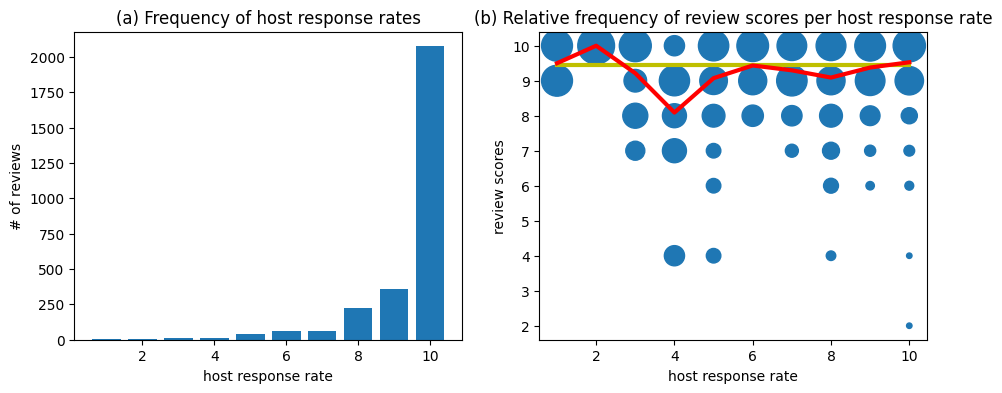

In [14]:
# frequency each host response rate value (Figure (a))
freq_per_host_response_rate=lis_simple[['host_response_rate_num']].copy().groupby(['host_response_rate_num'],as_index=False).value_counts(dropna=True).copy()
freq_per_host_response_rate.rename(columns={"count": "counts_per_host_response_rate"},inplace=True)

# frequency of each value pair: (host response rate, review score value)
freq_per_score_and_rate=lis_simple.groupby(['host_response_rate_num','review_scores_value'],as_index=False).value_counts(dropna=True).copy()
freq_per_score_and_rate.rename(columns={"count": "counts_per_per_score_and_rate"},inplace=True)

# relative (normalized) frequency of each value pair: (host response rate, review score value)   #  (Figure (b))
# normalization by the frequency of each response rate value
temp=pd.merge(freq_per_score_and_rate,freq_per_host_response_rate,on="host_response_rate_num")
rel_freq_per_score_and_rate=temp
rel_freq_per_score_and_rate['rel freq per score and rate']=temp["counts_per_per_score_and_rate"]/temp['counts_per_host_response_rate']

# average review scores for each host respose rate (red line in Figure (b))
avg_scores_per_rate=lis_simple.groupby(['host_response_rate_num'],as_index=False).mean().sort_values(by=['host_response_rate_num'],ascending=True)


# initialize plot
plt.rcParams['figure.figsize'] = [11,4]
fig, (ax1, ax2) = plt.subplots(1, 2)

# left plot - histogram of host response rates
plt.subplot(121)
plt.title("(a) Frequency of host response rates")
plt.xlabel('host response rate')
plt.ylabel('# of reviews')
plt.bar(freq_per_host_response_rate.host_response_rate_num,freq_per_host_response_rate.counts_per_host_response_rate)# , linestyle = '-', linewidth = '3',color="r")


# right plot - histogram showing relative frequency per score and rate
plt.subplot(122)
plt.title("(b) Relative frequency of review scores per host response rate")
plt.xlabel('host response rate')
plt.ylabel('review scores')
plt.scatter(rel_freq_per_score_and_rate.host_response_rate_num,rel_freq_per_score_and_rate.review_scores_value ,s=700*np.sqrt(rel_freq_per_score_and_rate['rel freq per score and rate']))

# plot average review score over all given Airbnb listings (yellow line) 
plt.plot(avg_scores_per_rate.host_response_rate_num,[avg_review_scores_value for i in range(10)], linestyle = '-', linewidth = '3',color="y")

# plot average review scores per host response rate (red line) 
plt.plot(avg_scores_per_rate.host_response_rate_num,avg_scores_per_rate.review_scores_value, linestyle = '-', linewidth = '3',color="r")



plt.show()

In Figure (a), one can recognize that the host response rate primarily takes values between 8 to 10, especially 10.
So even though analyzing what happens at lower host response rates is worth exploring, this region forms a statistically low contribution in the distribution.
In Figure (b), one can see from the red line that the data distribution among host response rate and review scores value is not revealing an intuitive monotonous increasing relationship between both quantities. 
At a high host response rate, one can recognize an expected high review score value.
However, the same holds at low host response rates.
Intermediate response rates, on the contrary, reveal lower review score values.

A possible explanation for this non-intuitive behavior in Figure (b) might lie in the fact that cases in which no host was requested constitute the majority of cases with response rates equal to zero.
Even if there is a guest's demand with less priority, then there is little reason for a quick host response and guests are still satisfied.
This can be seen at host response rates being one or two. But these cases are rare and statistics accordingly bad.
Once there is a fundamental reason for a quick host response, one highly values if this becomes true.
But if there is a fundamental reason and there is a weak response rate (about 3 to 5), reviewers will take this behavior negatively into account.
In that case, a significant number of reviewers even give quite low review scores down to 4.


#### Question 3: Does the rating depend on the reviewer's and host's gender?

It is from a business perspective interesting to take the different behavior of men and women into account.
For this purpose, analyzing the rating behavior of Airbnb guests to the host may depend on each person's gender.

In the next codeblock, a new dataframe "rev_lis", being an inner join of "rev" and "lis" with a selected set of columns, is introduced.

In [15]:
# initialize gender_gueser_object
d = gender.Detector()

# merge dataframes of interest
rev_lis=pd.merge(rev,lis,how='inner',left_on='listing_id',right_on='id')[['host_name','reviewer_name', 'room_type','review_scores_value']]

# add gender attributes for host and reviewer
rev_lis['reviewer_gender']=rev_lis['reviewer_name'].apply(d.get_gender)
rev_lis['host_gender']=rev_lis['host_name'].apply(d.get_gender)

Now, the mean review scores for the different cases: 
* men review host men,
* men review host women,
* women review host men,
* women review host women

are calculated.
Then, the upper calculation is done again for private room bookings, which possess more guest-host interference.

In [16]:
# determine the mean review scores for the different cases: men review men (mm), men review women (mf), women review men (fm) and women review women (ff)
mm=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="male") & (rev_lis['host_gender']=="male")].mean(skipna=True)
mf=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="male") & (rev_lis['host_gender']=="female")].mean(skipna=True)
fm=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="female") & (rev_lis['host_gender']=="male")].mean(skipna=True)
ff=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="female") & (rev_lis['host_gender']=="female")].mean(skipna=True)

# determine the mean review scores for private room bookings for the different cases: men review men (mmp), men review women (mfp), women review men (fmp) and women review women (ffp)
mmp=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="male") & (rev_lis['host_gender']=="male") & (rev_lis.room_type=='Private room')].mean(skipna=True)
mfp=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="male") & (rev_lis['host_gender']=="female") & (rev_lis.room_type=='Private room')].mean(skipna=True)
fmp=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="female") & (rev_lis['host_gender']=="male") & (rev_lis.room_type=='Private room')].mean(skipna=True)
ffp=rev_lis.review_scores_value[(rev_lis['reviewer_gender']=="female") & (rev_lis['host_gender']=="female") & (rev_lis.room_type=='Private room')].mean(skipna=True)

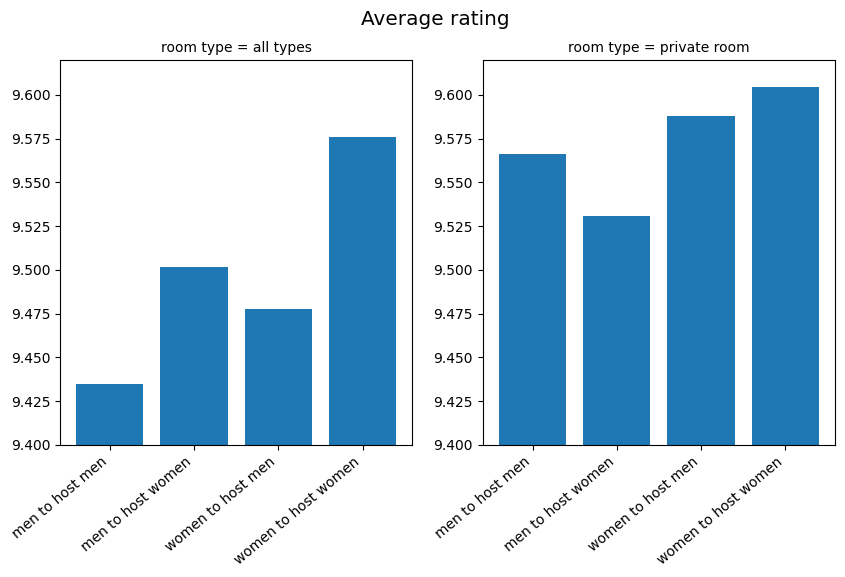

In [17]:
# plot to visualize gendersecific rating behavior for all bookings (Figure (a)) and private room bookings (Figure (b))

# values
values = [mm,mf,fm,ff]
valuesp = [mmp,mfp,fmp,ffp]

# tick labels
names = ['men to host men', 'men to host women', 'women to host men', 'women to host women']

# initialize plot
plt.rcParams['figure.figsize'] = [10,5]
fig, (ax1, ax2) = plt.subplots(1, 2)

# left plot
plt.subplot(121)
plt.bar(names, values)
ax = ax1
ax.set_ylim([9.4, 9.62])
ax.set_xticks(names)
ax.set_xticklabels(names, rotation=40,ha='right',va='top')
plt.title('room type = all types',fontsize='medium')

# right plot
plt.subplot(122)
plt.bar(names, valuesp)
ax = ax2
ax.set_ylim([9.4, 9.62])
ax.set_xticks(names)
ax.set_xticklabels(names, rotation=40 ,ha='right',va='top')
plt.title('room type = private room',fontsize='medium')

# major title
plt.suptitle('Average rating',fontsize='x-large')

plt.show()

With respect to all bookings irespective of the room type (left figure), one yields the following results.
Women and men give host women higher grades than if evaluating host men.
Men evaluate hosts with opposite sex higher than women do.
The highest average scores are yield if women evaluate host women.

However, ifthe stay is in a private room (right figure), then men evaluate host women lower than host men.
Hereby, the evaluations of women are always better than those by men, but still, women vote host women best.

Besides the general difference in rating among men and women, the different rating behavior in men for booking a private room suggests that men tend to feel a bit uncomfortable when it comes to sharing the apartment with a female host.

All in all, the results are hard to interpret, and it is challenging to find all the reasons as we only looked at a few variables. Also, the selection process for the booking might play an important role.
Nonetheless, from a business perspective, this phenomenon should be taken seriously.
